[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/facebookresearch/esm/blob/master/examples/variant_prediction.ipynb)

### RNA polymerase search with ESM

### Prerequisites (from ESM github)
- You will need the following modules : tqdm, matplotlib, numpy, pandas, seaborn, scipy, scikit-learn
- Sequence embeddings for phage metagenomic ORFs, obtained with batch ESM script:
```
python scripts/extract.py esm2_t33_650M_UR50D data/ncbi-bacteriophage-human-meta.fasta output/ncbi-bacteriophage-human-meta/ --repr_layers 0 32 33 --include mean per_tok
```


In [16]:
import torch
import matplotlib.pyplot as plt
from matplotlib import rcParams
import numpy as np
import pandas as pd
import seaborn as sns

import esm

In [17]:
import scipy
from scipy.spatial.distance import cosine, euclidean
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline
from sklearn.metrics import confusion_matrix
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.cluster import DBSCAN
from scipy.cluster.hierarchy import dendrogram
from sklearn.cluster import AgglomerativeClustering

### Add path to embeddings here:


In [309]:
FASTA_PATH = "../data/uniprotkb_2024_02_15.fasta"
BP_FASTA_PATH = "../data/ncbi-bacteriophage-human-meta.fasta"
EMB_PATH = "../output/uniprot_2024_02_15_reprs" # Path to directory of embeddings
BP_EMB_PATH = "../output/ncbi-bacteriophage-human-meta_reprs"
EMB_LAYER = 33

### Load RNAP embeddings

In [310]:
embs, headers = ([], [])
for header, _seq in esm.data.read_fasta(FASTA_PATH):
    fn = f'{EMB_PATH}/{header}.pt' # path to ESM output, per sequence
    emb = torch.load(fn)
    reprs = emb['mean_representations'][EMB_LAYER].numpy()
    embs.append(reprs)
    headers.append(header)

### Load bacteriophage metagenomic ORF embeddings

In [311]:
df_master = pd.read_csv('phage_metagenomic_embeddings.csv', header=None)
df_master = df_master.rename(columns={0: "ID", 1: "desc"})

In [312]:
embeddings = df_master.iloc[:, 2:].to_numpy()
embeddings.shape

(117312, 1280)

## Search representative ssRNAP embeddings against all ORFs

### Calculate cosine distance between ORFs for each ssRNAP

In [313]:
df_labels = df_master.copy()
for emb, header in zip(embs, headers):
    emb = emb.reshape(1, -1)
    id = header.split("|")[2].split(" ")[0] # Get just the gene ID
    distances = cosine_similarity(emb, embeddings)
    df_labels[id] = distances.reshape(-1, 1)
    df_labels[id] = 1 - df_labels[id]

### Assign labels based on BLAST annotations

In [314]:
df_labels['type'] = np.where(df_labels['desc'].str.contains("DNA-directed RNA poly|DNA directed RNA poly", case=False, regex=True), "DNA dir. RNAP", "other")
df_labels['type'] = np.where(df_labels['desc'].str.contains("RNA dependent|RNA-dependent", case=False, regex=True), "RNA dir. RNAP", df_labels['type'])
df_labels['type'] = np.where(df_labels['desc'].str.contains("DNA poly", case=False), "DNA dir. DNAP", df_labels['type'])

### Plot top 50 ORFs (ranked by cosine distance)

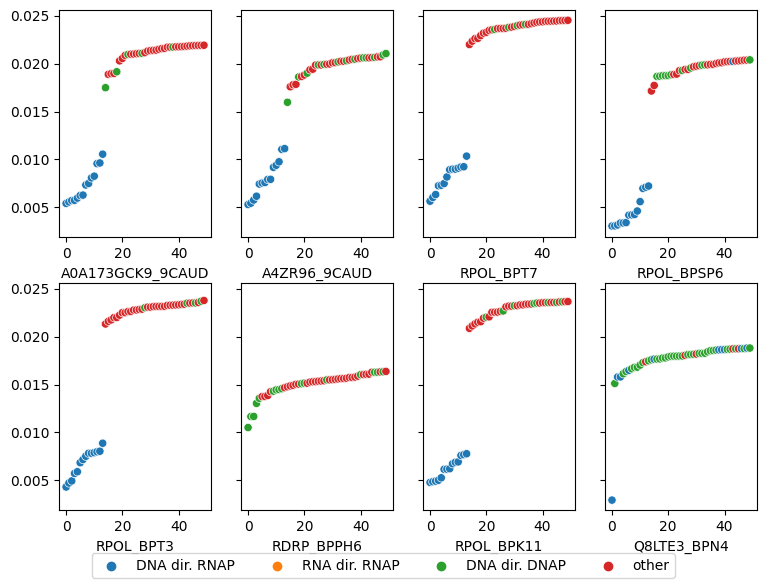

In [9]:
ids = list(df_labels.columns)[-9:-1]
from math import floor
hue_order = ["DNA dir. RNAP", "RNA dir. RNAP", "DNA dir. DNAP", "other"]

fig, ax = plt.subplots(2,4, sharey=True, figsize=(9,6.5))
for i in range(8):
    df_sorted = df_labels.sort_values(ids[i]).iloc[:50].reset_index(drop=True).reset_index()
    g = sns.scatterplot(data=df_sorted, y=ids[i], x="index", hue="type", hue_order=hue_order, ax=ax[floor(i/4)][i%4])
    g.get_legend().remove()
    g.set_ylabel("")
    g.set_xlabel(ids[i])

handles, labels = plt.gca().get_legend_handles_labels()
plt.figlegend(handles, labels, loc = 'lower center', ncol=5, labelspacing=0.)    
#ax[0].set_ylabel("rank")
#ax[1].set_ylabel("")
#fig.show()

In [322]:
#df_labels.sort_values("A4ZR96_9CAUD").head(n=20)

## Clustering ORF embeddings w/ DBSCAN

### All ORFs with the annotation "polymerase" 

In [259]:
df_pol_anno = df_master[df_master['desc'].str.contains("polymerase", case=False)]
df_pol_anno = df_pol_anno[df_pol_anno['desc'].str.contains("RNA", case=False)]

pol_embs = df_pol_anno.iloc[:,2:].to_numpy()
pol_embs.shape

(693, 1280)

In [260]:
grid_search = [0.0001*x for x in range(1, 300, 5)] # for cosine
result = []
cov = []
for param in grid_search:
    groups = DBSCAN(eps=param, min_samples=10, metric="cosine").fit(pol_embs).labels_
    result.append(len(set(groups)))
    cov.append(1 - (list(groups).count(-1)/693))

Text(0, 0.5, '% coverage')

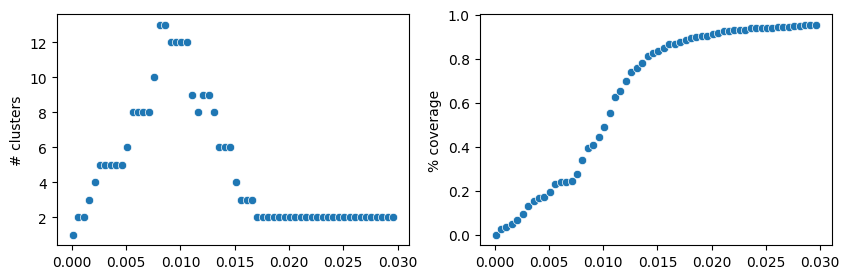

In [315]:
rcParams['figure.figsize'] = [10, 3]
fig, ax = plt.subplots(1,2)
sns.scatterplot(x=grid_search, y=result, ax=ax[0])
sns.scatterplot(x=grid_search, y=cov, ax=ax[1])
ax[0].set_ylabel("# clusters")
ax[1].set_ylabel("% coverage")

In [316]:
clustering = DBSCAN(eps=0.0075, min_samples=10, metric="cosine").fit(pol_embs)
df_pol_anno["DBSCAN"] = clustering.labels_.tolist()
df_pol_anno.sort_values("DBSCAN").loc[:,["ID", "desc", "DBSCAN"]].to_csv("dbscan_pol.csv")

In [317]:
num_pca_components = 60
pca = PCA(num_pca_components)
pol_pca = pca.fit_transform(pol_embs)

In [318]:
column_names = [f'PC{i+1}' for i in range(pol_pca.shape[1])]
df_pca = pd.DataFrame(data=pol_pca, columns=column_names)
df_pca["group"] = clustering.labels_.tolist()

In [319]:
df_cluster_h = df_pol_anno.drop(columns=["desc"])
df_cluster_h = df_cluster_h[df_cluster_h["DBSCAN"] != -1].set_index("ID")

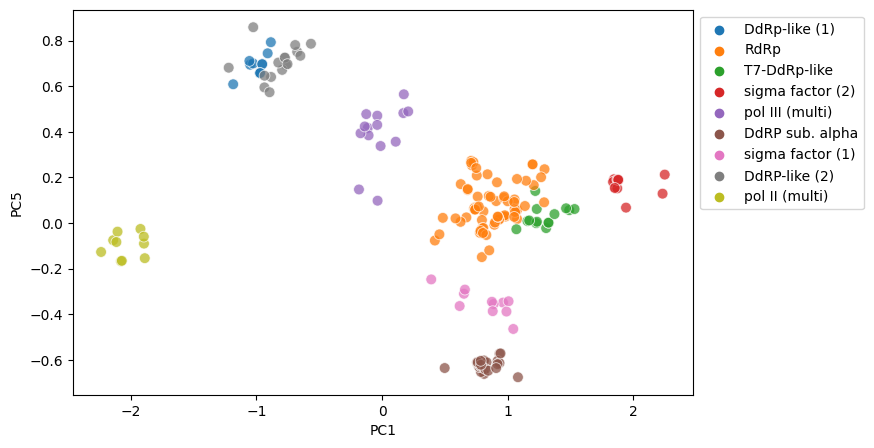

In [330]:
rcParams['figure.figsize'] = [8, 5]

labels = ["DdRp-like (1)", 
         "RdRp",
         "T7-DdRp-like",
          "sigma factor (2)",
         "pol III (multi)",
         "DdRP sub. alpha",
         "sigma factor (1)",
         "DdRP-like (2)",
         "pol II (multi)"]
df_pca = df_pca.query('group != -1')
df_pca["group"] = df_pca['group'].astype(str)
g = sns.scatterplot(data=df_pca, x="PC1", y="PC5", hue="group", s=60, alpha=0.75)
legend_handles, _= g.get_legend_handles_labels()
g.legend(legend_handles, labels, bbox_to_anchor=(1, 1))

In [334]:
labels = {0: "DdRp-like (1)", 
         1: "RdRp",
         2: "T7-DdRp-like",
         8: "sigma factor (2)",
         3: "pol III (multi)",
         4: "DdRP sub. alpha",
         5: "sigma factor (1)",
         6: "DdRP-like (2)",
         7: "pol II (multi)",
         -1: "undefined"}

In [337]:
df_pol_anno["annotation"] = [labels[cluster] for cluster in df_pol_anno["DBSCAN"].to_list()]

### All ORFs with the annotation "transposase" or "integrase"

In [321]:
df_transposase = df_master[df_master["desc"].str.contains("transposase|integrase", case=False, regex=True)]
embs = df_transposase.iloc[:,2:].to_numpy()
embs.shape

(857, 1280)

In [19]:
grid_search = [0.0001*x for x in range(10, 200, 5)] # for cosine
result = []
cov = []
for param in grid_search:
    groups = DBSCAN(eps=param, min_samples=8, metric="cosine").fit(embs).labels_
    result.append(len(set(groups)))
    cov.append(1 - (list(groups).count(-1)/847))

<AxesSubplot: >

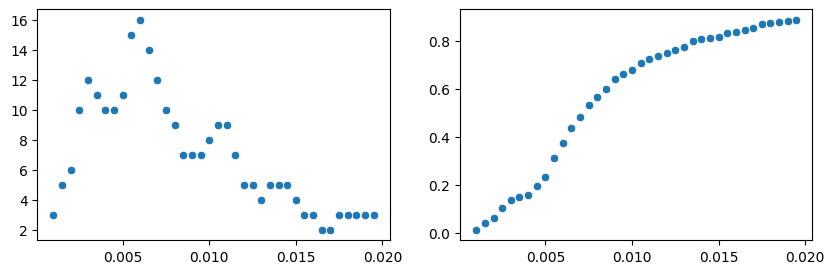

In [20]:
rcParams['figure.figsize'] = [10, 3]
fig, ax = plt.subplots(1,2)
sns.scatterplot(x=grid_search, y=result, ax=ax[0])
sns.scatterplot(x=grid_search, y=cov, ax=ax[1])

## Hierarchical clustering

In [325]:
def plot_dendrogram(model, **kwargs):
    # Create linkage matrix and then plot the dendrogram

    # create the counts of samples under each node
    counts = np.zeros(model.children_.shape[0])
    n_samples = len(model.labels_)
    for i, merge in enumerate(model.children_):
        current_count = 0
        for child_idx in merge:
            if child_idx < n_samples:
                current_count += 1  # leaf node
            else:
                current_count += counts[child_idx - n_samples]
        counts[i] = current_count

    linkage_matrix = np.column_stack(
        [model.children_, model.distances_, counts]
    ).astype(float)

    # Plot the corresponding dendrogram
    return dendrogram(linkage_matrix, orientation="left", **kwargs)

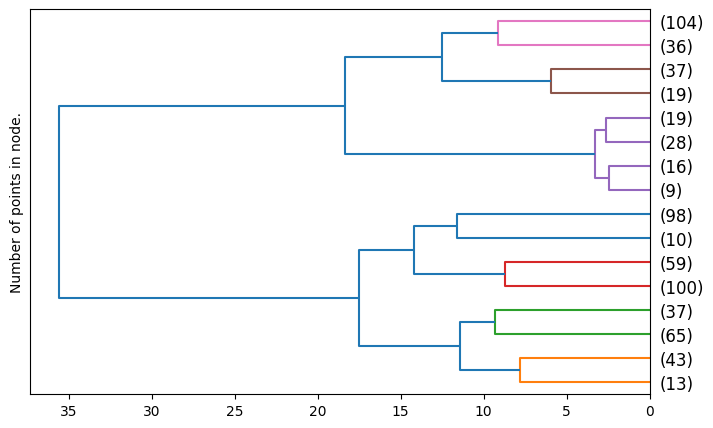

In [326]:
model = AgglomerativeClustering(n_clusters=8, compute_distances=True)
model = model.fit(pol_embs)
# plot the top three levels of the dendrogram
plot_dendrogram(model, truncate_mode="level", p=3, color_threshold=9.5)
plt.ylabel("Number of points in node.")
plt.show()

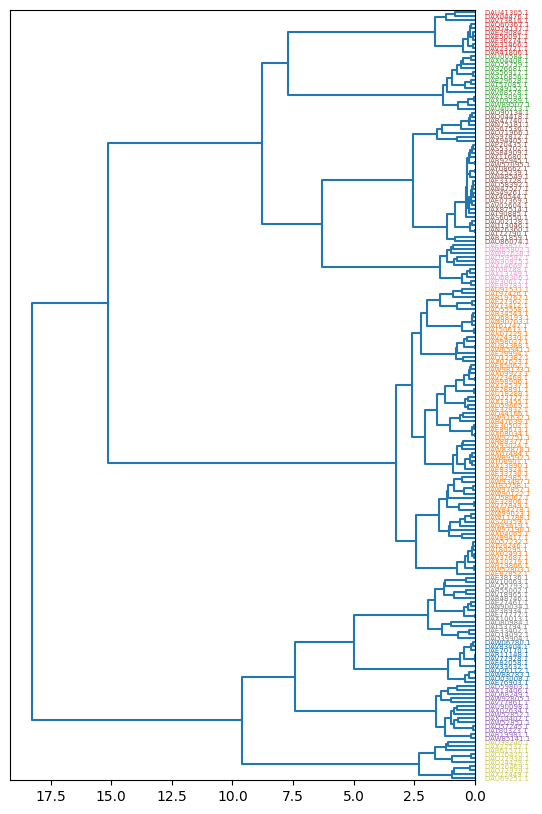

In [327]:
rcParams['figure.figsize'] = [6, 10]

# mappings between ID - DBSCAN cluster - color to color leaf labels by cluster from previous analysis
mapping = {}
for id, cluster in zip(list(df.index.values), df_cluster_h["DBSCAN"]):
    mapping[id] = cluster
color = {0: "#1f77b4", 1: "#ff8317", 2: "#3aa638", 8: "#d83435", 3: "#9467bd", 4: "#8f5a50", 5: "#ea99d1", 6: "#828282", 7: "#cccd58"}

# Calculate the distance between each sample
df = df_cluster_h.iloc[:,:-1]
Z = linkage(df, 'ward')
 
# Make the dendrogram
dendrogram(Z, labels=df.index, leaf_rotation=0, orientation="left", color_threshold=0)

# apply colors to leaves
ax = plt.gca()
xlbls = ax.get_ymajorticklabels()
num=-1
for lbl in xlbls:
    num+=1
    cluster = mapping[lbl.get_text()]
    value=color[int(cluster)]
    lbl.set_color(value)
plt.show()